In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
)
# from dike_model_function import DikeNetwork 
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant

warnings.filterwarnings("ignore")

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(6)
policy = {str(p): 0 for p in dike_model.levers}
policy_levers = pd.read_csv('data/policies_to_evaluate_scen0.csv')
policy_levers.drop(columns='Unnamed: 0', inplace=True)
policies = []
for index, row in policy_levers.iterrows():
    for p in policy_levers.columns:
        policy[p] = row[p]
    policies.append(Policy(f'Policy{index}', **policy))
# print(policies)

In [3]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000,policies=policies,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results

100%|██████████████████████████████████████| 3000/3000 [04:09<00:00, 12.02it/s]


In [4]:
df_outcomes = pd.DataFrame(outcomes)

In [16]:
print(df_outcomes)

      A.5_Expected Number of Deaths  A.5_Expected Annual Damage  \
0                          0.453665                4.552568e+08   
1                          0.000000                0.000000e+00   
2                          0.000000                0.000000e+00   
3                          0.000000                0.000000e+00   
4                          0.000000                0.000000e+00   
...                             ...                         ...   
2995                       0.000000                0.000000e+00   
2996                       0.000000                0.000000e+00   
2997                       0.003552                4.092715e+06   
2998                       0.000000                0.000000e+00   
2999                       0.000881                9.277024e+05   

      Expected Evacuation Costs  Expected Annual Damage  \
0                           0.0            7.557974e+08   
1                           0.0            1.884076e+09   
2                 

In [15]:
print(results)

(      A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                          26   80.487528       1.0   0.609026   70.680020   
1                           8  307.000890       1.5   0.950126  290.021085   
2                          57  297.272953       1.5   0.088334   65.490126   
3                           1  103.165284       1.5   0.958902  112.845795   
4                          52  224.163527       1.5   0.829326  297.245484   
...                       ...         ...       ...        ...         ...   
2995                       15  140.993316      10.0   0.691241  262.119194   
2996                       49  253.632037      10.0   0.409958  274.984386   
2997                        0  128.387185      10.0   0.889208   42.067670   
2998                       37  257.642819       1.5   0.366914  211.143369   
2999                       65   37.527365      10.0   0.176385  116.166716   

     A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ..

In [14]:
print(experiments['discount rate 0'])

0       3.5
1       2.5
2       2.5
3       3.5
4       4.5
       ... 
2995    3.5
2996    4.5
2997    3.5
2998    4.5
2999    2.5
Name: discount rate 0, Length: 3000, dtype: category
Categories (4, float64): [1.5, 2.5, 3.5, 4.5]


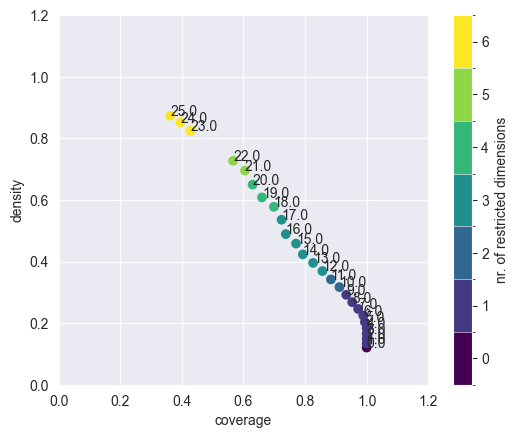

In [5]:
x = experiments

y = ((df_outcomes["A.5_Expected Number of Deaths"] > list(np.sort(df_outcomes["A.5_Expected Number of Deaths"]))[np.int64(0.80* len(df_outcomes["A.5_Expected Number of Deaths"]))])
    |(df_outcomes['A.5_Expected Annual Damage'] > list(np.sort(df_outcomes['A.5_Expected Annual Damage']))[np.int64(0.80* len(df_outcomes['A.5_Expected Annual Damage']))])
     )

prim_alg = prim.Prim(x, y, threshold=0.8,peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

In [6]:
pd.DataFrame(box1.inspect(19, style='data')[0][1]).to_csv('data\A5_space_Prim3.csv')

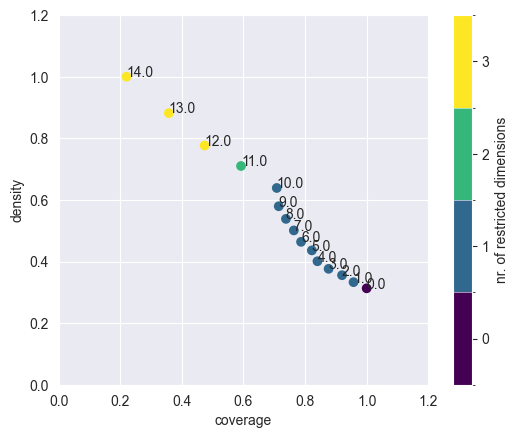

In [17]:
y = (
    (df_outcomes['Expected Number of Deaths'] > list(np.sort(df_outcomes["Expected Number of Deaths"]))[np.int64(0.8* len(df_outcomes['Expected Number of Deaths']))])
     |(df_outcomes['Expected Annual Damage'] > list(np.sort(df_outcomes["Expected Annual Damage"]))[np.int64(0.8* len(df_outcomes['Expected Annual Damage']))])
     )
# (df_feature_importance_out["Total Costs"] >= list(np.sort(df_feature_importance_out["Total Costs"]))[int(0.80* len(df_feature_importance_out["Total Costs"]))]) 
#      |
prim_alg = prim.Prim(x, y, threshold=0.8,peel_alpha=0.1)
box2 = prim_alg.find_box()
box2.show_tradeoff(annotated=True)
plt.show()

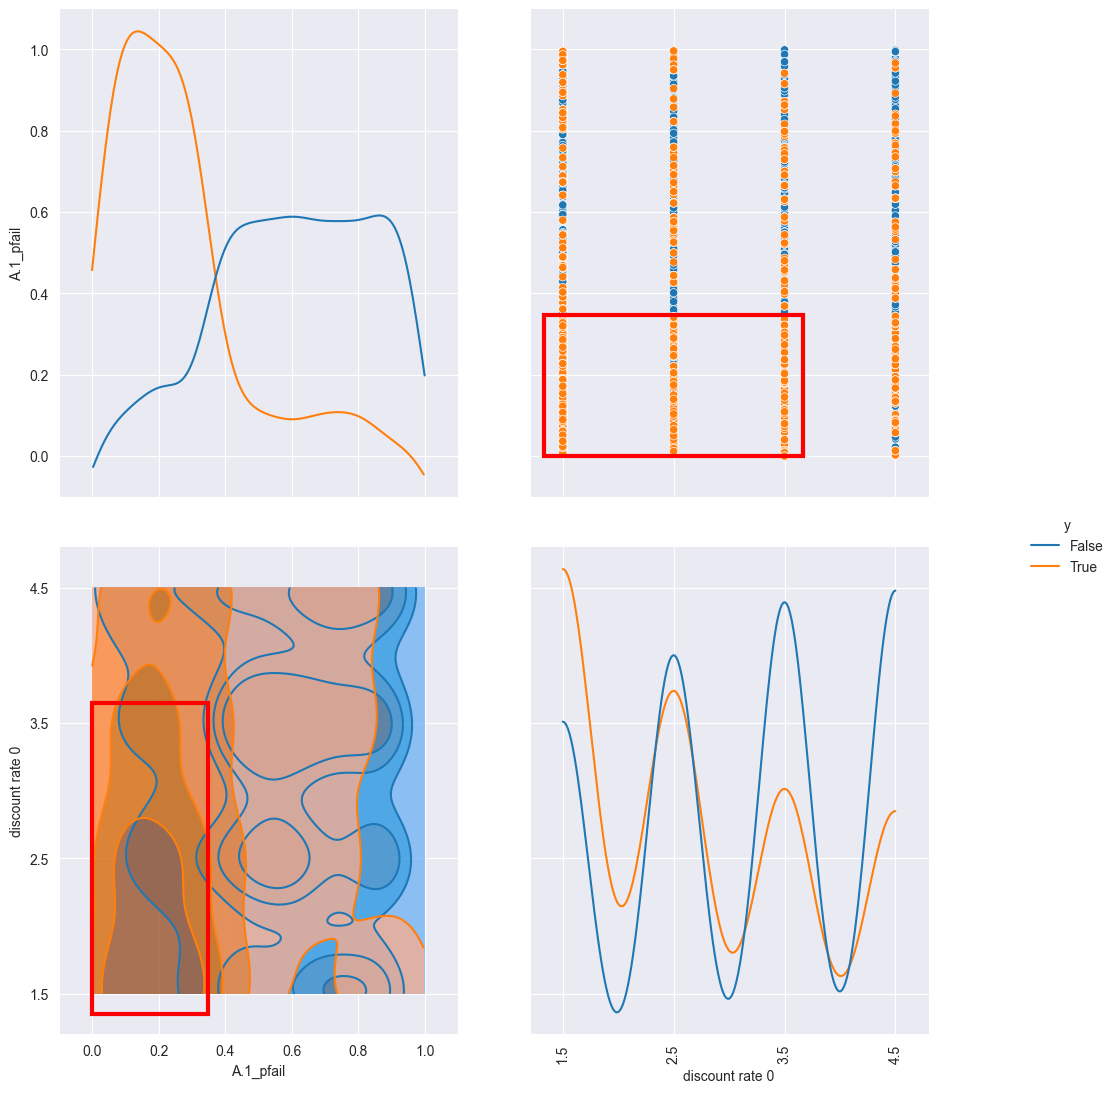

In [21]:
box2.select(11)
box2.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [18]:
pd.DataFrame(box2.inspect(11, style='data')[0][1]).to_csv('data\All_space_Prim3.csv')

In [19]:
variable = dike_model.uncertainties[0].name
print(variable)
df_param_space_all = (pd.read_csv('data/All_space_Prim3.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"}))
print(df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[0])
for uncertainty in dike_model.uncertainties:
        # print((variable in df_param_space_A5.Variable))
        variable = uncertainty.name
print(df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[0])

discount rate 0
{1.5, 2.5, 3.5}


IndexError: index 0 is out of bounds for axis 0 with size 0

In [22]:
from Convience_fun import create_scenario
import multirange as mr

df_param_space_A5 = (pd.read_csv('data/A5_space_Prim3.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"}))
df_param_space_all = (pd.read_csv('data/All_space_Prim3.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"}))

dike_model, planning_steps = get_model_for_problem_formulation(6)


def create_scenario_from_box(all, a5):
    para_list = []
    for uncertainty in dike_model.uncertainties:
        variable = uncertainty.name
        if (variable in list(df_param_space_A5.Variable)) & (a5 == True):
            min_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[1]].values[0])
            max_1 = float(
                df_param_space_A5[df_param_space_A5['Variable'] == variable][df_param_space_A5.columns[2]].values[0])

            para_list.append((min_1 + (max_1 - min_1) / 2))
        elif variable.startswith("d"):
            para_list.append(2.5)
        elif (variable in list(df_param_space_all.Variable)) & (all == True):
            min_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[1]].values[0])
            max_2 = float(
                df_param_space_all[df_param_space_all['Variable'] == variable][df_param_space_all.columns[2]].values[0])

            para_list.append((min_2 + (max_2 - min_2) / 2))
        elif variable == "A.0_ID flood wave shape":
            para_list.append(17)
        elif variable.endswith("Brate"):
            para_list.append(1.5)
        else:
            para_list.append((uncertainty.lower_bound + (uncertainty.upper_bound - uncertainty.lower_bound) / 2))

    return create_scenario(para_list)

Scenarios_MOEA = [create_scenario_from_box(all=True, a5=False), create_scenario_from_box(all=False, a5=True)]
import pickle

with open("data\ScenMultiMORDM", 'wb') as file:
    pickle.dump(Scenarios_MOEA, file) 

In [23]:
with open("data\ScenMultiMORDM", 'rb') as file2:
    Scenarios = pickle.load(file2)
Scenarios

[Scenario({'discount rate 0': 2.5, 'discount rate 1': 2.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 17, 'A.1_Bmax': 190.0, 'A.1_pfail': 0.17358412999075995, 'A.1_Brate': 1.5, 'A.2_Bmax': 190.0, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5, 'A.3_Bmax': 190.0, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5, 'A.4_Bmax': 190.0, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5, 'A.5_Bmax': 190.0, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5}),
 Scenario({'discount rate 0': 2.5, 'discount rate 1': 2.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 17, 'A.1_Bmax': 190.0, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5, 'A.2_Bmax': 190.0, 'A.2_pfail': 0.5861476274537795, 'A.2_Brate': 1.5, 'A.3_Bmax': 190.0, 'A.3_pfail': 0.6022982130500814, 'A.3_Brate': 1.5, 'A.4_Bmax': 190.0, 'A.4_pfail': 0.5903532047564555, 'A.4_Brate': 1.5, 'A.5_Bmax': 190.0, 'A.5_pfail': 0.12509505606467775, 'A.5_Brate': 1.5})]